# Testing Augmentation

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import random
import numpy as np
import os
# os.environ["TF_GPU_ALLOCATOR"]="cuda_malloc_async"
random_seed = 42
np.random.seed(random_seed)
random.seed(random_seed)
tf.random.set_seed(random_seed)

train_dir = r'..\data\train_aug_and_original'
validation_dir = r'..\data\val'
test_dir = r'..\data\test'

### Dataset:

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255)
val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    seed=random_seed
)

validation_generator = val_test_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    seed=random_seed
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    shuffle=False,
    seed=random_seed 
)


Found 15648 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


## Model:

In [95]:

# Building the model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [96]:
# Callbacks
# early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
# model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss')

In [97]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss')

## Train:

In [98]:
from math import ceil
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=ceil(train_generator.samples / train_generator.batch_size),
    validation_data=validation_generator,
    validation_steps=ceil(validation_generator.samples / validation_generator.batch_size),
    epochs=20,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/20
489/489 [==============================] - 34s 69ms/step - loss: 0.2176 - accuracy: 0.9139 - val_loss: 0.2819 - val_accuracy: 0.8125
Epoch 2/20
489/489 [==============================] - 34s 69ms/step - loss: 0.0913 - accuracy: 0.9656 - val_loss: 0.3162 - val_accuracy: 0.8125
Epoch 3/20
489/489 [==============================] - 34s 70ms/step - loss: 0.0664 - accuracy: 0.9751 - val_loss: 0.2533 - val_accuracy: 0.8750
Epoch 4/20
489/489 [==============================] - 34s 69ms/step - loss: 0.0448 - accuracy: 0.9833 - val_loss: 0.2086 - val_accuracy: 0.8750
Epoch 5/20
489/489 [==============================] - 34s 69ms/step - loss: 0.0356 - accuracy: 0.9866 - val_loss: 0.2836 - val_accuracy: 0.8750
Epoch 6/20
489/489 [==============================] - 34s 70ms/step - loss: 0.0274 - accuracy: 0.9895 - val_loss: 0.3002 - val_accuracy: 0.8750
Epoch 7/20
489/489 [==============================] - 34s 69ms/step - loss: 0.0235 - accuracy: 0.9912 - val_loss: 0.4353 - val_accuracy:

In [ ]:

loss, accuracy = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

19/19 [==============================] - 3s 127ms/step - loss: 2.9264 - accuracy: 0.7599
Test Accuracy: 75.99%


In [100]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

## Evaluation:

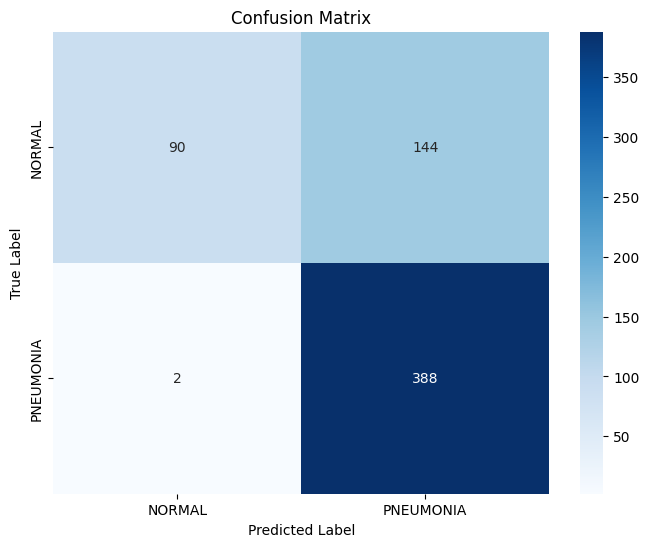

Classification Report
              precision    recall  f1-score   support

      NORMAL       0.98      0.38      0.55       234
   PNEUMONIA       0.73      0.99      0.84       390

    accuracy                           0.77       624
   macro avg       0.85      0.69      0.70       624
weighted avg       0.82      0.77      0.73       624

Accuracy Score: 76.60%


In [ ]:
# Predict the labels for test data
y_pred = model.predict(test_generator, steps=ceil(test_generator.samples / test_generator.batch_size))
y_pred = (y_pred > 0.5).astype(int).ravel()

# Get the true labels
y_true = test_generator.classes

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

report = classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys())
print('Classification Report')
print(report)

acc_score = accuracy_score(y_true, y_pred)
print(f'Accuracy Score: {acc_score * 100:.2f}%')